## Parameter Study

### Exercise 2.11 (programming) 
Make a figure analogous to Figure 2.6 for the nonstationary case outlined in Exercise 2.5. Include the constant-step-size $\epsilon$-greedy algorithm with $\alpha$=0.1. Use runs of 200,000 steps and, as a performance measure for each algorithm and parameter setting, use the average reward over the last 100,000 steps.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [100]:
from scipy.special import softmax
'''
    Bandit
    
    Represents a single k-bandit run
    k:                Number of arms
    T:                Steps to run for
    rewards:          Reward received for each step
    q:                Mean rewards
    Q:                Estimated rewards
    alpha:            Step size for reward estimate update
    N_a:              Number of times each action has been taken
    action_selector:  method to select next action
'''
class Bandit:
    
    def __init__(self, k, T, init_values, action_selector):
        self.k = k
        self.T = T
        self.rewards = np.zeros(T)
        self.q = np.zeros(k)
        self.q_sig = 0.1
        self.Q = init_values
        self.alpha = 0.1
        self.N_a = np.zeros(k)
        self.action_selector = action_selector
        
    def run(self):
        for i in range(self.T):
            action = self.action_selector(Q=self.Q)
            self.N_a[action] = self.N_a[action] + 1
            reward = np.random.normal(self.q[action], self.q_sig, 1)[0]
            self.rewards[i] = reward
            self.update_reward_estimate(reward, self.alpha)
            self.update_q()
        #self.plot_rewards()  
            
    def update_q(self):
        mu = 0
        sig = 0.01
        self.q = self.q + np.random.normal(mu, sig, size=self.q.shape)
    
    def update_reward_estimate(self, reward, step):
        self.Q = self.Q + step * (reward - self.Q)
        
    def plot_rewards(self):
        
        def rolling_average(data, window_width):
            csum_vec = np.cumsum(np.insert(data, 0, 0)) 
            return (csum_vec[window_width:] - csum_vec[:-window_width]) / window_width
        
        plt.figure()
        plt.plot(range(self.T), np.concatenate((np.zeros(99), rolling_average(self.rewards, 100))), 'r')
        
        
class Bandit_SGA(Bandit):
    
    def __init__(self, k, T, init_preferences, alpha_H):
        self.alpha_H = alpha_H
        self.H = np.zeros(k)
        self.pi = np.zeros(k)
        super().__init__(k, T, np.zeros(k), lambda x: x)
        
    def run(self):
        for i in range(self.T):
            action = self.choose_action()
            self.N_a[action] = self.N_a[action] + 1
            reward = np.random.normal(self.q[action], self.q_sig, 1)[0]
            self.rewards[i] = reward
            self.update_preferences(action, reward)
            super().update_reward_estimate(reward, 1/(i+1))
            super().update_q()
      
    def choose_action(self):
        self.pi = softmax(self.H)
        return np.random.choice(np.linspace(0, self.pi.size-1, self.pi.size, dtype=int), 1, p=self.pi)
    
    def update_preferences(self, action, reward):
        self.H = np.multiply(self.H - self.alpha_H * (reward - self.Q), self.pi)
        self.H[action] = (self.H[action] + self.alpha_H * (reward - self.Q[action]) * self.pi[action]) + (self.alpha_H * (reward - self.Q[action]) * (1 - self.pi[action]))

        
class Bandit_UCB(Bandit): 
    
    def __init__(self, k, T, c):
        self.c = c
        self.H = np.zeros(k)
        self.pi = np.zeros(k)
        super().__init__(k, T, np.zeros(k), lambda x: x)
        
    def run(self):
        for i in range(self.T):
            action = self.choose_action(i+1)
            self.N_a[action] = self.N_a[action] + 1
            reward = np.random.normal(self.q[action], self.q_sig, 1)[0]
            self.rewards[i] = reward
            super().update_reward_estimate(reward, self.alpha)
            super().update_q()
      
    def choose_action(self, t):
        if t < 2:
            return int(np.floor(np.random.rand(1)[0] * self.Q.size))
        else:
            return np.argmax(self.Q + self.c * np.sqrt(np.log(t) / self.N_a))
    

In [62]:
np.multiply(np.array([1,2,3]), np.array([4,5,6]))

array([ 4, 10, 18])

#### $\epsilon$-Greedy Method

In [48]:
trials_per_param_value = 100
T = 20000
T_meas = 10000 # Last _ steps are taken for performance measure
k = 10 # arms of the bandit

epsilon_range = np.logspace(0, 5, 6, base=2.0)
epsilon_range = epsilon_range * 1/128
avg_reward = np.zeros(epsilon_range.size)

def update_averages(old, new, n):
    return old + (new - old) / n

def make_actioneer(epsilon):
    def choose_action(Q):
        if (np.random.rand(1)[0] > epsilon):
            return np.argmax(Q)
        else:
            return int(np.floor(np.random.rand(1)[0] * Q.size)) # return random action
    return choose_action

for i, e in enumerate(epsilon_range):
    print(e)
    cuml_reward = 0
    for j in range(trials_per_param_value):
        bandit = Bandit(k, T, np.zeros(k), make_actioneer(e))
        bandit.run()
        cuml_reward += np.mean(bandit.rewards[-T_meas:])
    avg_reward[i] = cuml_reward / trials_per_param_value


0.0078125
0.015625
0.03125
0.0625
0.125
0.25


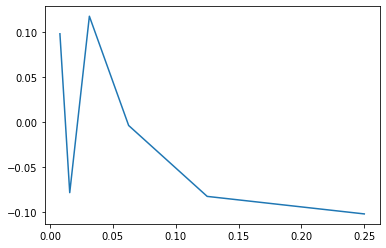

In [49]:
plt.plot(epsilon_range, avg_reward)

#### $\epsilon$-Greedy with Optimistic Initialization

In [50]:
trials_per_param_value = 100
T = 20000
T_meas = 10000 # Last _ steps are taken for performance measure
k = 10 # arms of the bandit

epsilon_range = np.logspace(0, 5, 6, base=2.0)
epsilon_range = epsilon_range * 1/128
avg_reward = np.zeros(epsilon_range.size)

def update_averages(old, new, n):
    return old + (new - old) / n

def make_actioneer(epsilon):
    def choose_action(Q):
        if (np.random.rand(1)[0] > epsilon):
            return np.argmax(Q)
        else:
            return int(np.floor(np.random.rand(1)[0] * Q.size)) # return random action
    return choose_action

for i, e in enumerate(epsilon_range):
    print(e)
    cuml_reward = 0
    for j in range(trials_per_param_value):
        bandit = Bandit(k, T, np.zeros(k) + 5, make_actioneer(e))
        bandit.run()
        cuml_reward += np.mean(bandit.rewards[-T_meas:])
    avg_reward[i] = cuml_reward / trials_per_param_value

0.0078125
0.015625
0.03125
0.0625
0.125
0.25


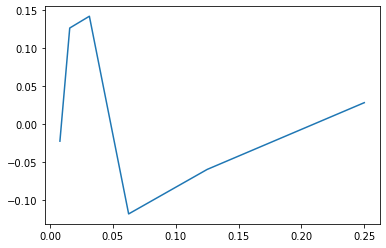

In [51]:
plt.plot(epsilon_range, avg_reward)

#### Gradient Bandit

In [91]:
trials_per_param_value = 10
T = 20000
T_meas = 10000 # Last _ steps are taken for performance measure
k = 10 # arms of the bandit

alpha_range = np.logspace(0, 7, 8, base=2.0)
alpha_range = alpha_range * 1/32
avg_reward = np.zeros(epsilon_range.size)

for i, alpha_H in enumerate(alpha_range):
    print(alpha_H)
    cuml_reward = 0
    for j in range(trials_per_param_value):
        bandit = Bandit_SGA(k, T, np.zeros(k), alpha_H)
        bandit.run()
        cuml_reward += np.mean(bandit.rewards[-T_meas:])
    avg_reward[i] = cuml_reward / trials_per_param_value

0.03125
0.0625
0.125
0.25
0.5
1.0
2.0
4.0


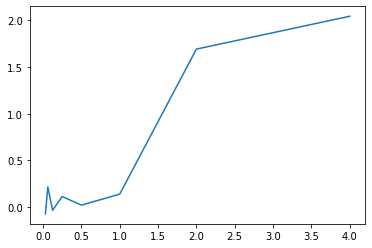

In [92]:
plt.plot(alpha_range, avg_reward)

#### UCB

In [113]:
trials_per_param_value = 10
T = 20000
T_meas = 10000 # Last _ steps are taken for performance measure
k = 10 # arms of the bandit

c_range = np.logspace(0, 7, 8, base=2.0)
c_range = c_range * 1/16
avg_reward = np.zeros(epsilon_range.size)

for i, c in enumerate(c_range):
    print(c)
    cuml_reward = 0
    for j in range(trials_per_param_value):
        bandit = Bandit_UCB(k, T, c)
        bandit.run()
        cuml_reward += np.mean(bandit.rewards[-T_meas:])
    avg_reward[i] = cuml_reward / trials_per_param_value

0.0625


<ipython-input-100-2d9716336327>:104: RuntimeWarning: divide by zero encountered in true_divide
  return np.argmax(self.Q + self.c * np.sqrt(np.log(t) / self.N_a))


0.125
0.25
0.5
1.0
2.0
4.0
8.0


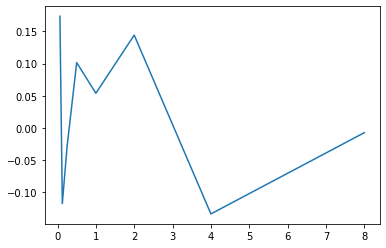

In [114]:
plt.plot(c_range, avg_reward)